In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
! pip install l5kit

     |████████████████████████████████| 92kB 6.2MB/s 
     |████████████████████████████████| 133kB 18.1MB/s 
     |████████████████████████████████| 42.9MB 125kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 5.8MB 42.2MB/s 
  Created wheel for pymap3d: filename=pymap3d-2.4.3-cp36-none-any.whl size=33551 sha256=a63d4758c91b99be3f506c7422e11025ece6c97bc292ac71bc49f1e661bf5850
  Stored in directory: /root/.cache/pip/wheels/be/e2/40/c642184272827b886ddb12661008199fe1460d4b05ddfc2670
Successfully built pymap3d
  Created wheel for ptable: filename=PTable-0.9.2-cp36-none-any.whl size=22905 sha256=00d25876fdb599dc7ed2ed81ef2a154aabad46ac71ab635ec7b090996164fe38
  Stored in directory: /root/.cache/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
  Created wheel for transforms3d: filename=transforms

In [ ]:
import os
import toml
from tqdm import tqdm
from prettytable import PrettyTable

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from l5kit.geometry import transform_points
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer

# Define paths for project folder and for data folder:

In [ ]:
PROJECT_PATH = '/gdrive/My Drive/Colab Notebooks/Projects/Lyft_motion_prediction'
PATH_TO_DATA = '/gdrive/My Drive/Colab Notebooks/Competitions/Lyft Motion Prediction/data_lyft'
MODEL_PATH = '/gdrive/My Drive/Colab Notebooks/Competitions/Lyft Motion Prediction/models_pytorch/models'

os.chdir(PROJECT_PATH)
os.environ["L5KIT_DATA_FOLDER"] = PATH_TO_DATA

In [ ]:
# Load config 
cfg = toml.load('config.toml')
cfg['raster_params']['map_type'] = 'py_satellite'

# Load data

In [ ]:
MODE = cfg['mode']

dm = LocalDataManager(None)
rasterizer = build_rasterizer(cfg, dm)

if MODE == 'train_sample':
  train_cfg = cfg['sample_data_loader']
if MODE == 'train_full':
  train_cfg = cfg['train_data_loader']
  
print(f'Current mode: {MODE}.')

Current mode: train_sample.


In [ ]:
train_zarr = ChunkedDataset(dm.require(train_cfg['key'])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer, min_frame_future=cfg['min_frame_future'])
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg['shuffle'],
                              batch_size=train_cfg['batch_size'],
                              num_workers=train_cfg['num_workers'])
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: you're running with custom min_frame_future of 50
  


# Visualisation of CVAE samples

In [ ]:
from train.train_utils import sample_trajectories_batch
from lyft_motion_prediction.utils.load_models import *
from utils.plot_utils import plot_cvae_predictions

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cvae_model = get_model('CVAE', cfg, device)

In [ ]:
# Sample data 
data_batch = next(iter(train_dataloader))
context = data_batch['image'].to(device)

In [ ]:
trajectories_batch = sample_trajectories_batch(cvae_model, context, device, cfg)

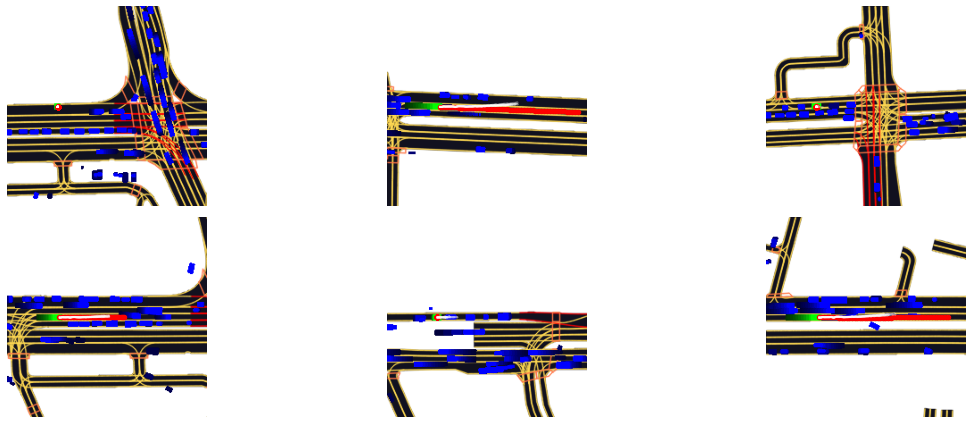

In [ ]:
plot_cvae_predictions(data_batch,
                      train_dataset,
                      trajectories_batch,
                      transform_points)

# Visualisation of agents motion prediction

In [ ]:
from lyft_motion_prediction.models import TrajectoriesPredictor

In [ ]:
# Load pretrained models
cvae_model = get_model('CVAE', cfg, device)
extractor_model = get_model('Extractor', cfg, device)

# Initialize complet model
model = TrajectoriesPredictor(cvae_model, extractor_mode, cfg, device)

In [ ]:
# Sample data 
data_batch = next(iter(train_dataloader))

In [ ]:
# Predict trajectories given frame
predicitons = model(data_batch)

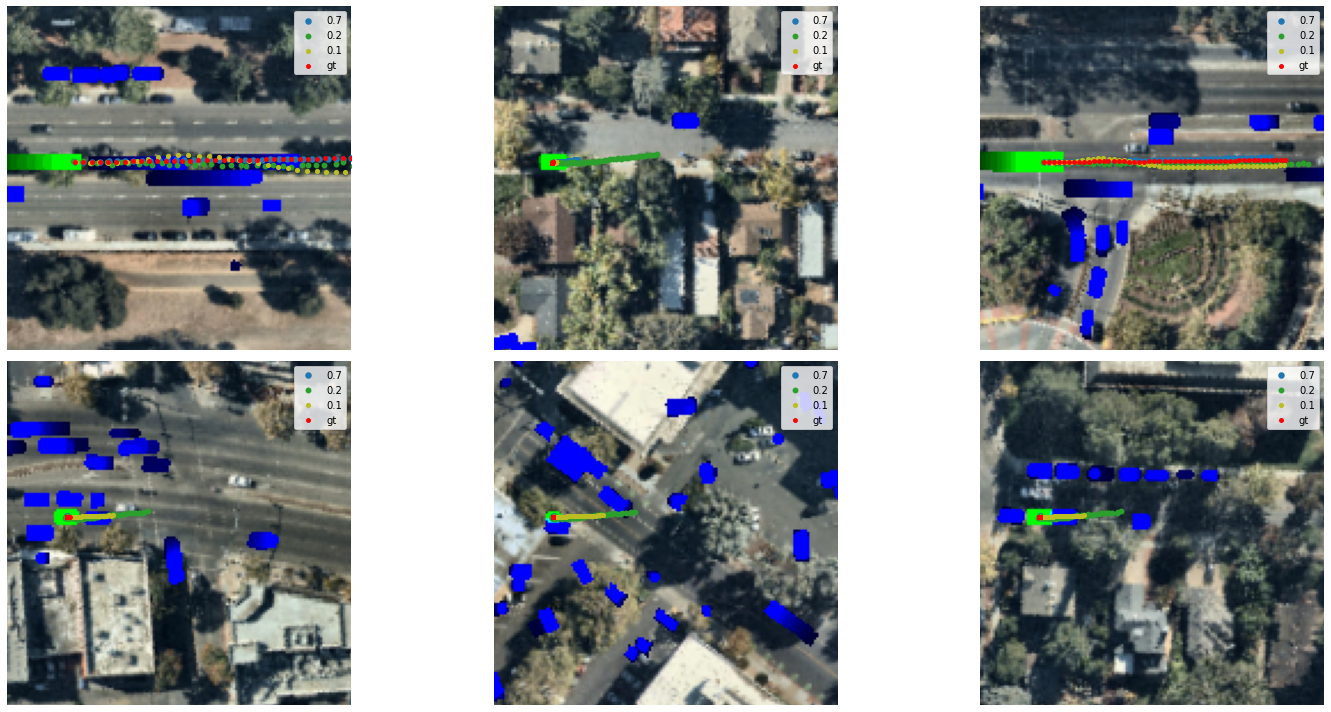

In [ ]:
plot_extr_predictions(data_batch,
                      train_dataset,
                      predicitons,
                      transform_points,
                      zoom=True)